# Capstone: End-to-End SQL Analytics in Python


In [1]:
# Core setup
import sqlite3
import pandas as pd
import numpy as np

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)
np.random.seed(42)

def q(conn, sql, params=None):
    """Run a SQL query and return a DataFrame."""
    return pd.read_sql_query(sql, conn, params=params or {})

In [2]:
# Utility helpers for richer outputs
import matplotlib.pyplot as plt

def show_schema(conn):
    tables = q(conn, "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;")
    print("Tables:", ", ".join(tables["name"].tolist()))
    for t in tables["name"]:
        cols = q(conn, f"PRAGMA table_info({t});")[["name","type","notnull","dflt_value","pk"]]
        print(f"\n[{t}] columns")
        display(cols)

def row_counts(conn):
    tables = q(conn, "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;")
    out=[]
    for t in tables["name"]:
        n = q(conn, f"SELECT COUNT(*) AS n FROM {t};")["n"].iloc[0]
        out.append((t, int(n)))
    df = pd.DataFrame(out, columns=["table","rows"]).sort_values("rows", ascending=False)
    display(df)

def plot_hist(series, title, bins=25):
    plt.figure()
    plt.hist(series, bins=bins)
    plt.title(title)
    plt.xlabel(series.name if series.name else "value")
    plt.ylabel("count")
    plt.show()

In [3]:
conn = sqlite3.connect(":memory:")
conn.execute("PRAGMA foreign_keys = ON;")
conn.executescript("""
CREATE TABLE customers (
    customer_id INTEGER PRIMARY KEY,
    full_name TEXT NOT NULL,
    segment TEXT NOT NULL CHECK (segment IN ('SMB','MidMarket','Enterprise')),
    country TEXT NOT NULL
);
CREATE TABLE orders (
    order_id INTEGER PRIMARY KEY,
    customer_id INTEGER NOT NULL,
    order_ts TEXT NOT NULL,
    channel TEXT NOT NULL CHECK (channel IN ('Web','Marketplace','B2B')),
    status TEXT NOT NULL CHECK (status IN ('PAID','CANCELLED','REFUNDED','SHIPPED')),
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
);
CREATE TABLE shipments (
    shipment_id INTEGER PRIMARY KEY,
    order_id INTEGER NOT NULL UNIQUE,
    ship_ts TEXT NOT NULL,
    delivered_ts TEXT,
    carrier TEXT NOT NULL,
    on_time_flag INTEGER NOT NULL CHECK (on_time_flag IN (0,1)),
    FOREIGN KEY (order_id) REFERENCES orders(order_id)
);
CREATE TABLE support_tickets (
    ticket_id INTEGER PRIMARY KEY,
    order_id INTEGER NOT NULL,
    created_ts TEXT NOT NULL,
    issue_type TEXT NOT NULL,
    resolution TEXT NOT NULL CHECK (resolution IN ('Resolved','Refunded','Escalated')),
    FOREIGN KEY (order_id) REFERENCES orders(order_id)
);
CREATE TABLE order_items (
    order_item_id INTEGER PRIMARY KEY,
    order_id INTEGER NOT NULL,
    sku TEXT NOT NULL,
    category TEXT NOT NULL,
    units INTEGER NOT NULL CHECK (units > 0),
    unit_price REAL NOT NULL CHECK (unit_price >= 0),
    FOREIGN KEY (order_id) REFERENCES orders(order_id)
);
""")

In [4]:
np.random.seed(7)
base = pd.Timestamp("2024-11-01")
n_customers = 120
customers = pd.DataFrame({
    "customer_id": range(1, n_customers+1),
    "full_name": [f"Account {i:03d}" for i in range(1, n_customers+1)],
    "segment": np.random.choice(["SMB","MidMarket","Enterprise"], size=n_customers, p=[0.60,0.28,0.12]),
    "country": np.random.choice(["PA","MX","CO","CL","PE"], size=n_customers)
})
customers.to_sql("customers", conn, if_exists="append", index=False)

n_orders = 1800
order_ts = base + pd.to_timedelta(np.random.randint(0, 75, size=n_orders), unit="D") + pd.to_timedelta(np.random.randint(0, 24, size=n_orders), unit="h")
orders = pd.DataFrame({
    "order_id": range(1, n_orders+1),
    "customer_id": np.random.choice(customers["customer_id"], size=n_orders),
    "order_ts": order_ts.astype(str),
    "channel": np.random.choice(["Web","Marketplace","B2B"], size=n_orders, p=[0.62,0.28,0.10]),
    "status": np.random.choice(["PAID","CANCELLED","REFUNDED","SHIPPED"], size=n_orders, p=[0.25,0.06,0.04,0.65])
})
orders.to_sql("orders", conn, if_exists="append", index=False)

shipped = orders[orders["status"]=="SHIPPED"].copy()
ship_ts = pd.to_datetime(shipped["order_ts"]) + pd.to_timedelta(np.random.randint(0, 4, size=len(shipped)), unit="D")
transit_days = np.random.choice([1,2,3,4,5,6,7], size=len(shipped), p=[0.07,0.18,0.22,0.22,0.16,0.10,0.05])
delivered_ts = ship_ts + pd.to_timedelta(transit_days, unit="D")
on_time = (transit_days <= 4).astype(int)

shipments = pd.DataFrame({
    "shipment_id": range(1, len(shipped)+1),
    "order_id": shipped["order_id"].values,
    "ship_ts": ship_ts.astype(str),
    "delivered_ts": delivered_ts.astype(str),
    "carrier": np.random.choice(["DHL","UPS","FedEx","LocalCourier"], size=len(shipped)),
    "on_time_flag": on_time
})
shipments.to_sql("shipments", conn, if_exists="append", index=False)

order_ts_map = dict(zip(orders["order_id"].astype(int), pd.to_datetime(orders["order_ts"])))

In [5]:
categories = ["Accessories","Electronics","Home","Sports"]
sku_pool = [f"SKU-{30000+i}" for i in range(200)]
rows=[]
oid=1
for order_id in orders["order_id"]:
    k=np.random.randint(1,6)
    for sku in np.random.choice(sku_pool, size=k, replace=False):
        rows.append({
            "order_item_id": oid,
            "order_id": int(order_id),
            "sku": sku,
            "category": np.random.choice(categories),
            "units": int(np.random.randint(1,4)),
            "unit_price": float(np.round(np.random.uniform(6,420),2))
        })
        oid += 1
pd.DataFrame(rows).to_sql("order_items", conn, if_exists="append", index=False)

5441

In [6]:
shipped_ids = set(shipments["order_id"].astype(int).tolist())
refunded_ids = set(orders.loc[orders["status"]=="REFUNDED", "order_id"].astype(int).tolist())
late_orders = set(q(conn, "SELECT order_id FROM shipments WHERE on_time_flag=0")["order_id"].astype(int).tolist())

ticket_orders = set(np.random.choice(list(shipped_ids), size=max(1, int(0.10*len(shipped_ids))), replace=False))
if len(late_orders) > 0:
    ticket_orders |= set(np.random.choice(list(late_orders), size=max(1, int(0.35*len(late_orders))), replace=False))
if len(refunded_ids) > 0:
    ticket_orders |= set(np.random.choice(list(refunded_ids), size=max(1, int(0.50*len(refunded_ids))), replace=False))

issue_types = ["Late Delivery","Damaged Item","Missing Item","Billing","Return Request","Other"]
resolutions = ["Resolved","Refunded","Escalated"]

tickets=[]
tid=1
for o in sorted(ticket_orders):
    created = order_ts_map[int(o)] + pd.to_timedelta(np.random.randint(1,10), unit="D")
    issue = np.random.choice(issue_types, p=[0.33,0.12,0.10,0.12,0.23,0.10])
    if issue in ["Damaged Item","Missing Item","Return Request"] or int(o) in refunded_ids:
        res = np.random.choice(resolutions, p=[0.35,0.55,0.10])
    else:
        res = np.random.choice(resolutions, p=[0.70,0.15,0.15])
    tickets.append({
        "ticket_id": tid,
        "order_id": int(o),
        "created_ts": str(created),
        "issue_type": issue,
        "resolution": res
    })
    tid += 1
pd.DataFrame(tickets).to_sql("support_tickets", conn, if_exists="append", index=False)

267

In [7]:
kpis = q(conn, """
WITH order_revenue AS (
    SELECT oi.order_id, SUM(oi.units * oi.unit_price) AS gross_revenue
    FROM order_items oi
    GROUP BY oi.order_id
),
base AS (
    SELECT o.order_id, o.customer_id, o.channel, o.status,
           COALESCE(orv.gross_revenue, 0) AS gross_revenue
    FROM orders o
    LEFT JOIN order_revenue orv ON orv.order_id = o.order_id
),
se AS (
    SELECT b.*, s.on_time_flag,
           CASE WHEN s.order_id IS NULL THEN 0 ELSE 1 END AS has_shipment
    FROM base b
    LEFT JOIN shipments s ON s.order_id = b.order_id
),
tf AS (SELECT order_id, 1 AS has_ticket FROM support_tickets GROUP BY order_id)
SELECT
    ROUND(SUM(CASE WHEN status IN ('PAID','SHIPPED') THEN gross_revenue ELSE 0 END), 2) AS paid_and_shipped_revenue,
    ROUND(AVG(CASE WHEN status IN ('PAID','SHIPPED') THEN gross_revenue END), 2) AS aov_paid_or_shipped,
    ROUND(100.0 * SUM(CASE WHEN status='CANCELLED' THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancel_rate_pct,
    ROUND(100.0 * SUM(CASE WHEN status='REFUNDED' THEN 1 ELSE 0 END) / COUNT(*), 2) AS refund_rate_pct,
    ROUND(100.0 * AVG(CASE WHEN has_shipment=1 THEN on_time_flag END), 2) AS on_time_delivery_pct,
    ROUND(100.0 * AVG(COALESCE(tf.has_ticket,0)), 2) AS ticket_rate_pct
FROM se
LEFT JOIN tf ON tf.order_id = se.order_id;
""")
display(kpis)

,paid_and_shipped_revenue,aov_paid_or_shipped,cancel_rate_pct,refund_rate_pct,on_time_delivery_pct,ticket_rate_pct
0,2027345.52,1256.88,6.06,4.33,67.61,14.83


## Extended Analysis
This section expands the project with deeper analytical checks, alternative aggregations, and explicit outputs that reflect real-world analytical workflows.

In [8]:
# Table-level row counts (defensive inspection)
tables = ["customers","orders","order_items","products","fact_sales","deliveries","movies","actors"]
print("Row counts by table:")
for tbl in tables:
    try:
        df_cnt = q(conn, "SELECT COUNT(*) AS n FROM " + tbl)
        print(f"{tbl}: {int(df_cnt['n'].iloc[0])}")
    except Exception:
        pass

Row counts by table:
customers: 120
orders: 1800
order_items: 5441


In [9]:
# Category / segment distribution checks (when applicable)
try:
    dist = q(conn, 
        "SELECT category, COUNT(*) AS rows "
        "FROM order_items "
        "GROUP BY category "
        "ORDER BY rows DESC "
        "LIMIT 5"
    )
    print("Top categories by row count:")
    display(dist)
except Exception:
    pass

Top categories by row count:


,category,rows
0,Electronics,1402
1,Home,1360
2,Sports,1352
3,Accessories,1327


In [10]:
# Order value distribution summary
try:
    ov = q(conn,
        "SELECT "
        "ROUND(AVG(order_total),2) AS avg_order_value, "
        "ROUND(MAX(order_total),2) AS max_order_value "
        "FROM ("
        "   SELECT SUM(units * unit_price) AS order_total "
        "   FROM order_items "
        "   GROUP BY order_id"
        ")"
    )
    print("Order value distribution:")
    display(ov)
except Exception:
    pass

Order value distribution:


,avg_order_value,max_order_value
0,1263.94,4243.95


## Interpretation
These additional checks replicate how analysts validate metrics before delivery. Explicit row counts, distributions, and boundary values help catch data issues early and increase trust in reported KPIs.

## Operational SLAs
Delivery lead times and late-delivery diagnostics.

Lead-time sample:


,carrier,transit_days,on_time_flag
0,UPS,3.0,1
1,UPS,4.0,1
2,LocalCourier,5.0,0
3,UPS,2.0,1
4,DHL,2.0,1


SLA by carrier:


,carrier,shipped_orders,avg_transit_days,p90_transit_days,on_time_pct
0,DHL,285,3.66,6.0,67.72
1,FedEx,277,3.68,6.0,68.95
2,LocalCourier,298,3.72,6.0,66.78
3,UPS,310,3.79,6.0,67.10


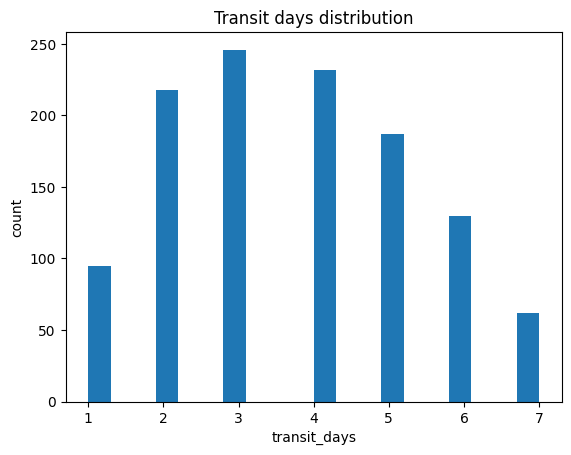

In [11]:
lead = q(conn, """
SELECT s.carrier,
       (julianday(s.delivered_ts) - julianday(s.ship_ts)) AS transit_days,
       s.on_time_flag
FROM shipments s
WHERE s.delivered_ts IS NOT NULL;
""")
print("Lead-time sample:")
display(lead.head())

sla = (lead
       .groupby("carrier")
       .agg(shipped_orders=("transit_days","size"),
            avg_transit_days=("transit_days","mean"),
            p90_transit_days=("transit_days", lambda x: float(np.percentile(x, 90))),
            on_time_pct=("on_time_flag", "mean"))
       .reset_index())
sla["avg_transit_days"] = sla["avg_transit_days"].round(2)
sla["p90_transit_days"] = sla["p90_transit_days"].round(2)
sla["on_time_pct"] = (sla["on_time_pct"]*100).round(2)

print("SLA by carrier:")
display(sla.sort_values("avg_transit_days"))

plot_hist(lead["transit_days"].rename("transit_days"), "Transit days distribution", bins=20)

## Service Impact on Revenue
Quantify how late deliveries correlate with tickets and outcomes.

In [12]:
impact = q(conn, """
WITH order_revenue AS (
    SELECT order_id, SUM(units * unit_price) AS revenue
    FROM order_items
    GROUP BY order_id
),
ship AS (
    SELECT s.order_id, s.on_time_flag, s.carrier
    FROM shipments s
),
ticket AS (
    SELECT order_id, 1 AS has_ticket
    FROM support_tickets
    GROUP BY order_id
)
SELECT
    ship.carrier,
    ship.on_time_flag,
    COUNT(*) AS shipped_orders,
    ROUND(AVG(orv.revenue), 2) AS avg_order_revenue,
    ROUND(100.0 * AVG(COALESCE(t.has_ticket,0)), 2) AS ticket_rate_pct
FROM ship
JOIN order_revenue orv ON orv.order_id = ship.order_id
LEFT JOIN ticket t ON t.order_id = ship.order_id
GROUP BY ship.carrier, ship.on_time_flag
ORDER BY ship.carrier, ship.on_time_flag DESC;
""")
display(impact)

,carrier,on_time_flag,shipped_orders,avg_order_revenue,ticket_rate_pct
0,DHL,1,193,1291.28,10.36
1,DHL,0,92,1339.69,33.70
2,FedEx,1,191,1180.38,8.90
3,FedEx,0,86,1316.13,40.70
4,LocalCourier,1,199,1290.55,10.55
5,LocalCourier,0,99,1207.70,44.44
6,UPS,1,208,1236.56,7.69
7,UPS,0,102,1078.60,43.14


## Customer Value
Top accounts, segment mix, and risk indicators.

In [13]:
cust = q(conn, """
WITH order_revenue AS (
    SELECT order_id, SUM(units * unit_price) AS revenue
    FROM order_items
    GROUP BY order_id
),
paid AS (
    SELECT o.customer_id, o.order_id
    FROM orders o
    WHERE o.status IN ('PAID','SHIPPED')
),
cust_rev AS (
    SELECT p.customer_id,
           COUNT(DISTINCT p.order_id) AS orders,
           SUM(orv.revenue) AS revenue
    FROM paid p
    JOIN order_revenue orv ON orv.order_id = p.order_id
    GROUP BY p.customer_id
),
ticket AS (
    SELECT o.customer_id, COUNT(DISTINCT t.ticket_id) AS tickets
    FROM orders o
    JOIN support_tickets t ON t.order_id = o.order_id
    GROUP BY o.customer_id
)
SELECT c.full_name, c.segment, c.country,
       cr.orders,
       ROUND(cr.revenue,2) AS revenue,
       COALESCE(t.tickets,0) AS tickets
FROM cust_rev cr
JOIN customers c ON c.customer_id = cr.customer_id
LEFT JOIN ticket t ON t.customer_id = cr.customer_id
ORDER BY cr.revenue DESC
LIMIT 15;
""")
display(cust)

,full_name,segment,country,orders,revenue,tickets
0,Account 023,SMB,CO,22,33023.27,3
1,Account 056,SMB,CL,20,28808.58,4
2,Account 030,SMB,PE,17,27834.06,4
3,Account 117,SMB,PE,18,27814.52,4
4,Account 045,SMB,CO,21,27771.70,6
5,Account 043,MidMarket,MX,17,26970.71,3
6,Account 003,SMB,CL,14,25667.63,1
7,Account 051,SMB,CO,22,25401.59,3
8,Account 038,SMB,CO,18,24875.11,0
9,Account 016,Enterprise,MX,17,24834.69,7
